# ONP 데이터 분석 
## 0. 분석 목적
## 1. 라이브러리 불러오기
## 2. 데이터 불러오기
## 3. EDA
## 4. 전처리
## 5. 모델링
## 6. 결론

## 0. 분석목적
 이번 분석은 크게 2가지 방향으로 진행될 예정이다.
 * 기사의 특징을 바탕으로 share 수 예측하기
 * 기사의 특징을 바탕으로 유명한 기사인지 아닌지 분류하기

## 1. 라이브러리 불러오기
기본 라이브러리를 불러오고, 회귀와 분류 모델에서 사용할 알고리즘 또한 불러온다.

In [1]:
#기본 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set(style="ticks")

In [2]:
#머신러닝 알고리즘 및 유틸리티
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from scipy import stats
from scipy.stats import norm,skew
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

C:\Users\student\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
#KERAS!!!!!
#from keras.layers import Dense 
#from keras.models import Sequential

In [4]:
#GPU 사용체크
#from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

## 2. 데이터 불러오기
* 기본 정보 살펴보기
    1. 데이터의 차원
    2. 데이터 구성 확인
    3. 각 속성별 요약 통계 확인
    4. 타켓 변수 특징 확인

In [5]:
#데이터를 불러온다.
df=pd.read_csv("./datasets/OnlineNewsPopularity.csv")

In [6]:
#차원을 확인한다.
print(df.shape)

(39644, 61)


In [7]:
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


In [8]:
#데이터 구성 확인
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 61 columns):
url                               39644 non-null object
 timedelta                        39644 non-null float64
 n_tokens_title                   39644 non-null float64
 n_tokens_content                 39644 non-null float64
 n_unique_tokens                  39644 non-null float64
 n_non_stop_words                 39644 non-null float64
 n_non_stop_unique_tokens         39644 non-null float64
 num_hrefs                        39644 non-null float64
 num_self_hrefs                   39644 non-null float64
 num_imgs                         39644 non-null float64
 num_videos                       39644 non-null float64
 average_token_length             39644 non-null float64
 num_keywords                     39644 non-null float64
 data_channel_is_lifestyle        39644 non-null float64
 data_channel_is_entertainment    39644 non-null float64
 data_channel_is_bus              396

메타 데이터인 기사의 URL과 타임델타임은 분석에 사용하지 않는다.

In [9]:
#요약통계
df.iloc[:,:16].describe(include="all")

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus
count,39644,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000
unique,39644,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,http://mashable.com/2014/12/01/russia-blocks-v...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,354.530471,10.398749,546.514731,0.548216,0.996469,0.689175,10.883690,3.293638,4.544143,1.249874,4.548239,7.223767,0.052946,0.178009,0.157855
std,NaN,214.163767,2.114037,471.107508,3.520708,5.231231,3.264816,11.332017,3.855141,8.309434,4.107855,0.844406,1.909130,0.223929,0.382525,0.364610
min,NaN,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,NaN,164.000000,9.000000,246.000000,0.470870,1.000000,0.625739,4.000000,1.000000,1.000000,0.000000,4.478404,6.000000,0.000000,0.000000,0.000000
50%,NaN,339.000000,10.000000,409.000000,0.539226,1.000000,0.690476,8.000000,3.000000,1.000000,0.000000,4.664082,7.000000,0.000000,0.000000,0.000000
75%,NaN,542.000000,12.000000,716.000000,0.608696,1.000000,0.754630,14.000000,4.000000,4.000000,1.000000,4.854839,9.000000,0.000000,0.000000,0.000000


데이터를 대략적으로 살펴보니 이진변수(0,1) 또한 실수형으로 처리되었음을 알 수 있다.

In [10]:
#타겟변수 확인
#확인하는 과정에서 URL을 제외한 칼럼의 첫자에 공백문자가 있음을 발견했다. 이를 제거하고 진행한다.
df.columns=df.columns.str.replace(' ', '')
target=df["shares"]
target.head()

0     593
1     711
2    1500
3    1200
4     505
Name: shares, dtype: int64

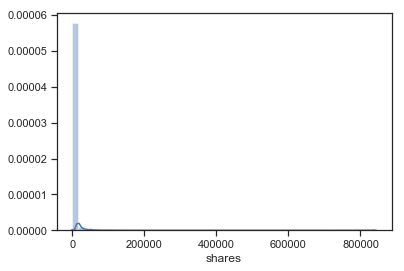

In [11]:
sns.distplot(target)

분포의 상태가 너무 안 좋은 것 같지만, 일단 진행해보도록 한다.

In [12]:
#왜도와 첨도를 살펴본다.
print("Skewness: %f" % target.skew())
print("Kurtosis: %f" % target.kurt())

Skewness: 33.963885
Kurtosis: 1832.672657


헬인데?

## 3. EDA

Main Feature와 target으로 구성된 데이터 프레임을 새로 만든다.

In [13]:
df_eda=df.drop(["url","timedelta"], axis=1)

In [14]:
df_eda["pop"]=pd.DataFrame(np.where(df_eda["shares"]>=1400,1,0))

In [15]:
df_eda.columns

Index(['n_tokens_title', 'n_tokens_content', 'n_unique_tokens',
       'n_non_stop_words', 'n_non_stop_unique_tokens', 'num_hrefs',
       'num_self_hrefs', 'num_imgs', 'num_videos', 'average_token_length',
       'num_keywords', 'data_channel_is_lifestyle',
       'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min',
       'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg',
       'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares',
       'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00',
       'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negat

In [16]:
df_eda["pop"].values

array([0, 0, 1, ..., 1, 0, 0])

In [17]:
df_eda["pop"].value_counts()

1    21154
0    18490
Name: pop, dtype: int64

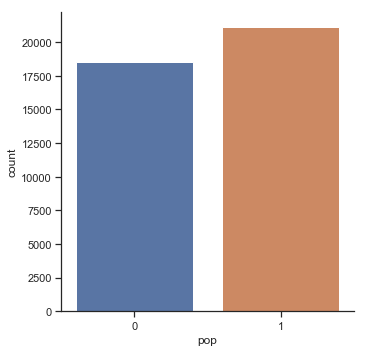

In [18]:
sns.catplot(x="pop", kind="count", data=df_eda)

자료도 정리 된거 같으니 항상 귀찮게 구는 결측치와 이상치를 찾아보자

In [19]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [20]:
missing_values = missing_values_table(df_eda)
missing_values

Your selected dataframe has 60 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


잭팟! 클-----린한 데이터입니다. 이제는 아웃 라이어를 볼 차례입니다.

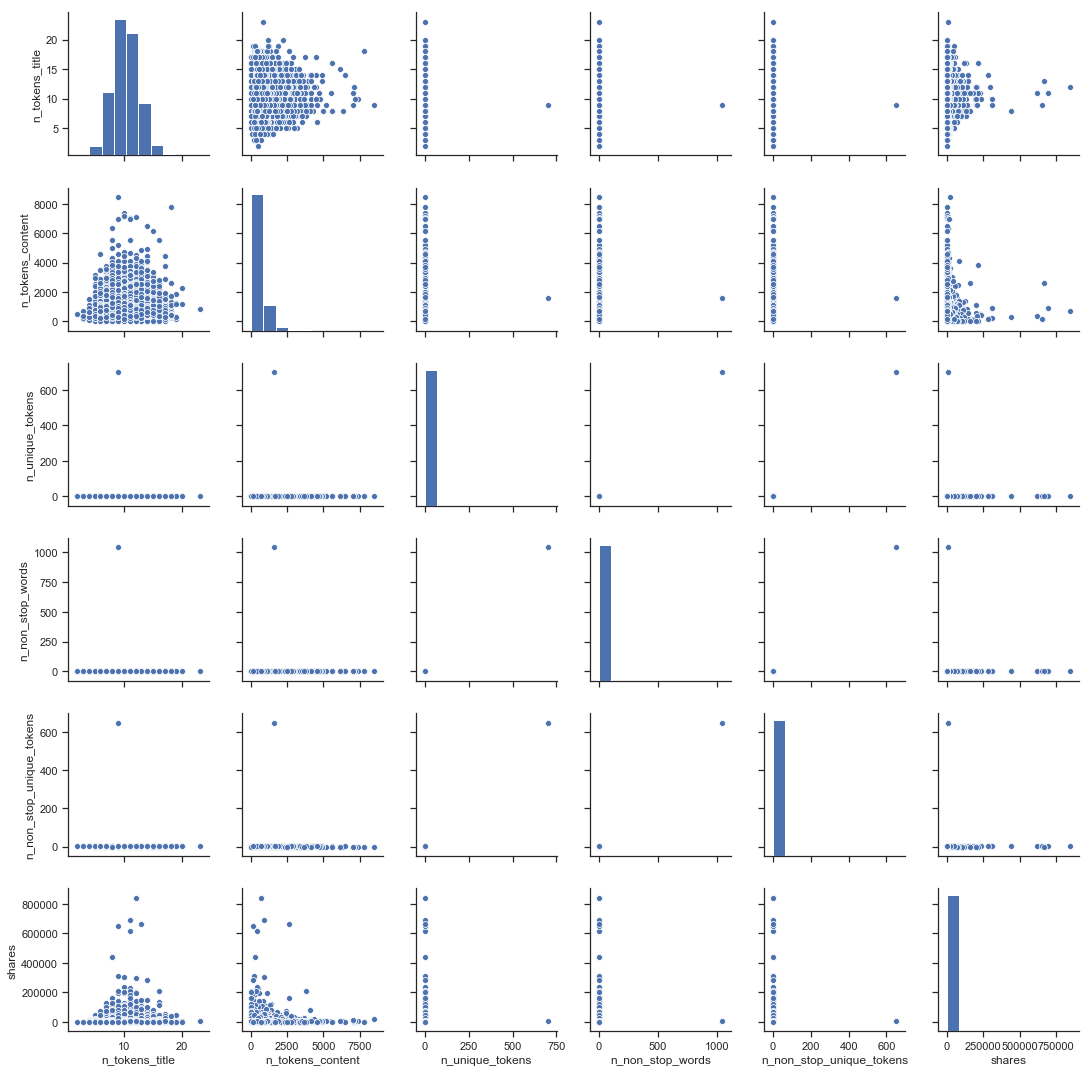

In [21]:
#모든 항목에 대해 그리는 것은 59*59의 그래프를 만들기 때문에 간단하게 살펴보고 이상치의 유무를 본다.
sns.pairplot(df_eda[['n_tokens_title', 'n_tokens_content', 'n_unique_tokens','n_non_stop_words', 'n_non_stop_unique_tokens','shares']])

아웃 라이어가 존재한다는 것을 알게 되었고 Z-score를 통한 이상치 제거를 나중에 진행한다. 

우선은 상관 관계를 보도록 한다.

In [22]:
#상관계수
correlations = df_eda.corr()['shares'].sort_values()

In [23]:
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 kw_max_min                    0.030114
kw_avg_min                    0.030406
global_subjectivity           0.031604
num_imgs                      0.039388
kw_min_avg                    0.039551
kw_avg_max                    0.044686
num_hrefs                     0.045404
self_reference_max_shares     0.047115
self_reference_min_shares     0.055958
self_reference_avg_sharess    0.057789
kw_max_avg                    0.064306
LDA_03                        0.083771
kw_avg_avg                    0.110413
pop                           0.199891
shares                        1.000000
Name: shares, dtype: float64

Most Negative Correlations:
 LDA_02                          -0.059163
data_channel_is_world           -0.049497
avg_negative_polarity           -0.032029
average_token_length            -0.022007
max_negative_polarity           -0.019300
min_negative_polarity           -0.019297
data_channel_is_entertainment   -0.017006
LDA_04                          -

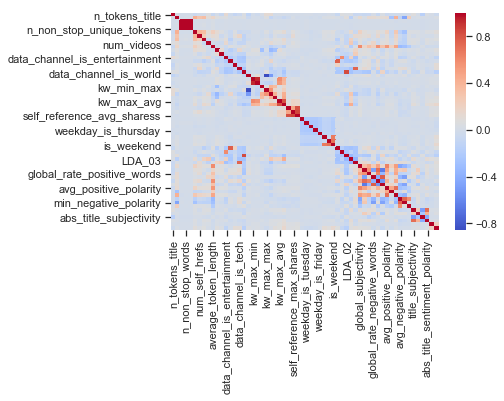

In [24]:
#상관관계를 보는 것만큼 괜찮은 EDA가 없다.
sns.heatmap(df_eda.corr(),cmap='coolwarm');

## 4. 전처리

* 이상치 제거

* Normalization and standardization

* 자료형 맞춰주기

* 왜도 조정하기

In [25]:
df_eda[(np.abs(stats.zscore(df_eda)) < 3).all(axis=1)].shape

(21009, 60)

In [26]:
#이상치를 제거한다.
df_no_out=df_eda[(np.abs(stats.zscore(df_eda)) < 3).all(axis=1)]


 mu = 2426.01 and sigma = 3555.51



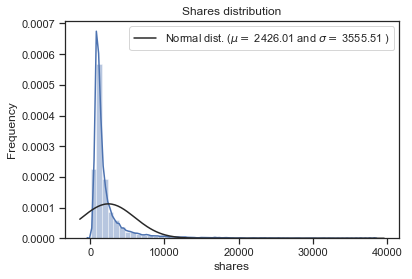

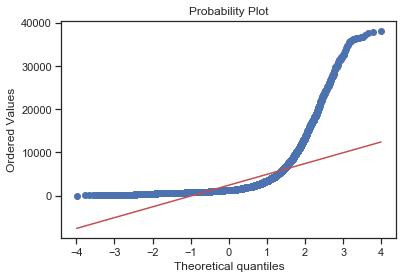

In [27]:
#정규화 + 스케일링 진행 전 데이터 살펴보기
#Check the new distribution 
sns.distplot(df_no_out["shares"] , fit=norm);

(mu, sigma) = norm.fit(df_no_out["shares"])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Shares distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df_no_out["shares"], plot=plt)
plt.show()


 mu = 7.34 and sigma = 0.84



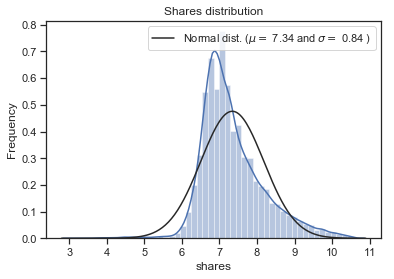

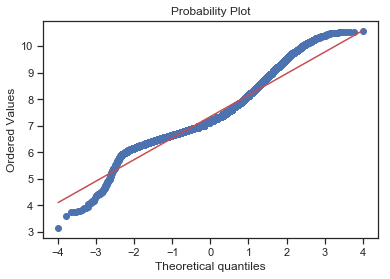

In [28]:
#일단 로그를 취하고 살펴본다.
df_no_out.loc[:,"shares"] = np.log1p(df_no_out.loc[:,"shares"])

#확률분포를 살펴본다.
sns.distplot(df_no_out.loc[:,"shares"] , fit=norm);

(mu, sigma) = norm.fit(df_no_out["shares"])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))


plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Shares distribution')

#QQ-plot을 살펴본다.
fig = plt.figure()
res = stats.probplot(df_no_out.loc[:,"shares"], plot=plt)
plt.show()

In [29]:
#변수명을 줄여주고 다음 단계로 넘어간다.
data=df_no_out

일부 항목에 대해 자료형을 바꿔줄 필요가 있다. "is_"라는 문자열이 들어가는 항목은 사실 이진변수이기 때문에 실수형 보다는 정수형으로 처리하는 것이 안전하다.

In [30]:
data.filter(regex='is_').head()

,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,is_weekend
3075,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3076,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3079,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3080,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3083,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [31]:
data[data.filter(regex='is_').columns]=data[data.filter(regex='is_').columns].astype("int64", copy=True)

In [32]:
data.filter(regex='is_').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21009 entries, 3075 to 39642
Data columns (total 14 columns):
data_channel_is_lifestyle        21009 non-null int64
data_channel_is_entertainment    21009 non-null int64
data_channel_is_bus              21009 non-null int64
data_channel_is_socmed           21009 non-null int64
data_channel_is_tech             21009 non-null int64
data_channel_is_world            21009 non-null int64
weekday_is_monday                21009 non-null int64
weekday_is_tuesday               21009 non-null int64
weekday_is_wednesday             21009 non-null int64
weekday_is_thursday              21009 non-null int64
weekday_is_friday                21009 non-null int64
weekday_is_saturday              21009 non-null int64
weekday_is_sunday                21009 non-null int64
is_weekend                       21009 non-null int64
dtypes: int64(14)
memory usage: 2.4 MB


In [34]:
data.describe(include="all")

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,pop
count,21009.000000,21009.000000,21009.000000,2.100900e+04,21009.000000,21009.000000,21009.00000,21009.000000,21009.000000,21009.000000,...,21009.000000,21009.000000,21009.000000,21009.000000,21009.000000,21009.000000,21009.000000,21009.000000,21009.000000,21009.000000
mean,10.461992,517.244276,0.547082,1.000000e+00,0.697540,9.673235,3.02794,3.495026,0.670808,4.698656,...,0.760608,-0.251431,-0.515562,-0.099357,0.256786,0.058025,0.344337,0.126577,7.340923,0.468847
std,2.063260,336.561186,0.091190,3.328885e-09,0.088944,7.278003,2.44397,5.346156,1.660483,0.273076,...,0.208932,0.105220,0.274614,0.057607,0.308140,0.214319,0.188500,0.182420,0.838445,0.499040
min,5.000000,34.000000,0.240102,1.000000e+00,0.268631,0.000000,0.00000,0.000000,0.000000,3.624585,...,0.050000,-0.640741,-1.000000,-0.388889,0.000000,-0.714286,0.000000,0.000000,3.135494,0.000000
25%,9.000000,270.000000,0.483871,1.000000e+00,0.641463,5.000000,1.00000,1.000000,0.000000,4.512456,...,0.600000,-0.313394,-0.700000,-0.125000,0.000000,0.000000,0.166667,0.000000,6.786717,0.000000
50%,10.000000,420.000000,0.543814,1.000000e+00,0.696774,8.000000,3.00000,1.000000,0.000000,4.693694,...,0.800000,-0.246759,-0.500000,-0.100000,0.100000,0.000000,0.500000,0.000000,7.170888,0.000000
75%,12.000000,677.000000,0.604348,1.000000e+00,0.754011,12.000000,4.00000,3.000000,1.000000,4.874372,...,1.000000,-0.185317,-0.300000,-0.050000,0.478571,0.136364,0.500000,0.200000,7.741099,1.000000
max,16.000000,1956.000000,0.972973,1.000000e+00,1.000000,44.000000,14.00000,29.000000,13.000000,6.816754,...,1.000000,0.000000,0.000000,0.000000,1.000000,0.800000,0.500000,0.800000,10.550617,1.000000


## 5. 모델
### 5.1 Linear Regression
### 5.2 XGBRegressor
### 5.3 MLP
### 5.4 Random Forest
### 5.5 XGBClassifier
### 5.6 MLP

모델링을 진행할 때 사람들이 간과하는 것 중 하나가 모델이 가진 특징과 성능을 파악하고 문제에 접근해야한다는 것이다. 닭 잡는데 소 잡는 칼을 들고 와서 일을 크게 벌린다면 자원 낭비로 이어질 수 있다. 이번 회귀분석 및 분류 문제에서도 다양한 모델로 결과를 보는 것도 좋지만, 간단한 모델로 충분한 성능이 나온다면 그걸로도 괜찮을 수 있다는 점을 배웠으면 좋겠다.

분석 목적에 따라 shares의 수를 예측하고, 인기기사를 분류해내도록한다.

우선은 shares의 수를 예측하는 회귀 모형을 만든다.

### 5.1 선형 회귀
선형 회귀 단계에서 필요한 데이터를 나누는 것으로 모델링을 시작한다.

In [35]:
#독립변수와 종속변수로 나누어준다.
x=data.drop(["shares","pop"], axis=1)
y=data.shares

In [36]:
#훈련 데이터와 테스트 데이터로 나누어준다.
train_x, test_x, train_y, test_y=train_test_split(x,y, test_size=0.3, random_state=523)

In [37]:
#단순회귀 모형 생성
lm = LinearRegression()
lm_scores = -cross_val_score(lm, train_x, train_y, cv=10, scoring="neg_mean_squared_error")
print('Scores =', lm_scores)
print('CV mse: %.3f +/- %.3f' % (np.mean(lm_scores), np.std(lm_scores)))

Scores = [0.59296796 0.58797931 0.61919516 0.60363117 0.59371681 0.6411836
 0.5804316  0.61890932 0.62008214 0.64037789]
CV mse: 0.610 +/- 0.020


In [38]:
lm.fit(train_x, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [39]:
#검증시간
predictions = lm.predict(test_x)

In [40]:
r2_score(y_pred=predictions, y_true=test_y)

0.13268632968820526

별론데?

In [41]:
cofs=pd.DataFrame({"Feature":x.columns,"Coefficients":np.transpose(lm.coef_, )})

In [42]:
cofs.Coefficients.abs().sort_values(ascending=False).head()

3     4.618464e+06
11    7.844151e+03
14    3.589142e+03
45    7.847664e+00
44    2.311011e+00
Name: Coefficients, dtype: float64

### 5.2 XGBRegressor
XGB는 핫한 기법이고 성능도 좋다고해서 한 번 써봤습니다.

추가로 그리드 서치+CV를 활용하여 모델을 구성해봤습니다.

그리드 서치와 관련된 내용은 저희 교재 317쪽, 5.2 그리드 서치 챕터에 있습니다.

연산 시간이 길기 때문에 이점 주의해주시기 바랍니다.

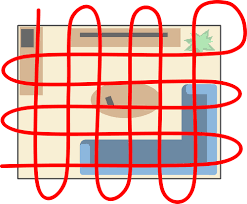

In [59]:
n_estimators = [150, 200]
max_depth = [2, 4, 6]
learning_rate = [0.01, 0.1, 1.0]
random_state=[523]
param_grid = dict(learning_rate=learning_rate, max_depth=max_depth, n_estimators=n_estimators, random_state=random_state)

In [60]:
xgb_reg = XGBRegressor()
grid_search = GridSearchCV(xgb_reg, param_grid, n_jobs=-1)
grid_result = grid_search.fit(train_x, train_y)

In [61]:
print(r2_score(test_y, grid_result.best_estimator_.predict(test_x)))

0.15719356274251273


In [62]:
#가장 좋은 조합과 성능을 볼 수 있습니다.
result_data=pd.DataFrame(grid_result.cv_results_)
result_data.sort_values("rank_test_score").head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
7,4.312933,0.051616,0.0290,0.000817,0.1,2,200,523,"{'learning_rate': 0.1, 'max_depth': 2, 'n_esti...",0.163064,0.156738,0.160385,0.160062,0.002593,1,0.231017,0.233509,0.224421,0.229649,0.003834
6,3.509667,0.394291,0.0284,0.003150,0.1,2,150,523,"{'learning_rate': 0.1, 'max_depth': 2, 'n_esti...",0.163173,0.154523,0.158755,0.158817,0.003532,2,0.214527,0.216218,0.210397,0.213714,0.002445
8,7.123200,1.266572,0.0422,0.010897,0.1,4,150,523,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti...",0.157951,0.157010,0.154686,0.156549,0.001372,3,0.383426,0.389435,0.375465,0.382775,0.005722


In [63]:
grid_result.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=523,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

### 5.3 Random Forest
랜덤포레스트 분류기를 사용하기 전에 우선은 분류 문제로 만들기 위해 shares>=1400인 경우를 pop=1 나머지 경우를 pop=0으로 하는 pop속성을 추가한 뒤 모델링을 이어간다.

랜덤 포레스트의 경우, 몇 개의 변수를 가져갈 것인가? 파라미터는 어떻게 튜닝할 것인가에 대한 방법도 존재한다.

알고리즘에 대한 이해를 바탕으로 파라미터 튜닝을 생각하고 있다면 정말 편리한 툴이다.

In [66]:
clf_x=data.drop(["pop","shares"], axis=1)
clf_y=data["pop"]

In [67]:
train_clf_x, test_clf_x, train_clf_y, test_clf_y=train_test_split(clf_x, clf_y, test_size=0.3, random_state=523)

In [68]:
estimator = RandomForestClassifier()
selector = RFECV(estimator, step=1, cv=5)
selector = selector.fit(train_clf_x, train_clf_y)
selector.support_ 

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

Optimal number of features : 57


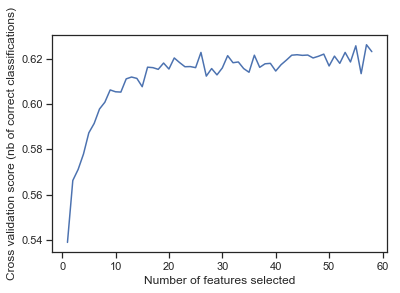

In [69]:
print("Optimal number of features : %d" % selector.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.show()

In [77]:
param_grid = { 
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,6,8],
    'criterion' :['gini', 'entropy'],
    'random_state' :[523]
}

In [78]:
CV_rfc = GridSearchCV(estimator=estimator, param_grid=param_grid, cv= 5)
grid_rf=CV_rfc.fit(train_clf_x, train_clf_y)

In [79]:
grid_rf.best_params_.

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 200,
 'random_state': 523}

In [80]:
#Train and take a look...
rf_clf=RandomForestClassifier(n_estimators=200, criterion='entropy', random_state=523, max_depth=8, max_features='auto')
rf_scores = cross_val_score(rf_clf, train_clf_x, train_clf_y, cv=5)
print('Scores =', rf_scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(rf_scores), np.std(rf_scores)))

Scores = [0.65873555 0.66077498 0.64977899 0.65963958 0.66428571]
CV accuracy: 0.659 +/- 0.005


In [81]:
#Fit
rf_clf.fit(train_clf_x, train_clf_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=523, verbose=0, warm_start=False)

In [82]:
#Predictions...
pred_y=rf_clf.predict(test_clf_x)

In [83]:
print(classification_report(y_pred=pred_y,y_true=test_clf_y))

             precision    recall  f1-score   support

          0       0.67      0.72      0.70      3380
          1       0.65      0.60      0.62      2923

avg / total       0.66      0.66      0.66      6303



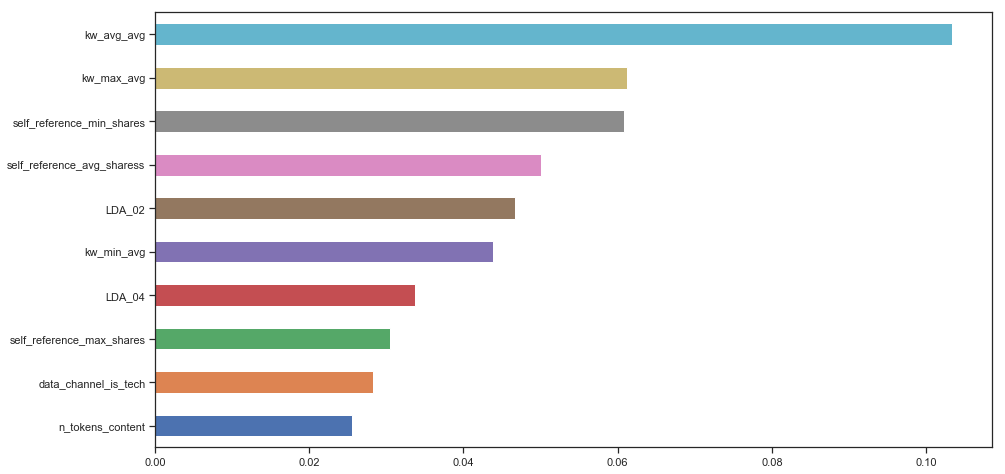

In [84]:
feat_importances = pd.Series(rf_clf.feature_importances_, index=train_clf_x.columns)

plt.rcParams['figure.figsize'] = [15, 8]
feat_importances.nlargest(10).sort_values().plot(kind='barh')

### 5.4 XGBClassifier

In [85]:
n_estimators = [100, 150, 200]
max_depth = [2, 4, 6]
learning_rate = [0.01, 0.1, 1.0]
random_state=[523]
param_grid = dict(learning_rate=learning_rate, max_depth=max_depth, n_estimators=n_estimators, random_state=random_state)

In [86]:
xgb_clf = XGBClassifier()
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state = 523)
grid_search = GridSearchCV(xgb_clf, param_grid, n_jobs=-1, cv=folds)
grid_result = grid_search.fit(train_clf_x, train_clf_y)

In [87]:
print(classification_report(y_true=test_clf_y, y_pred=grid_result.best_estimator_.predict(test_clf_x)))

             precision    recall  f1-score   support

          0       0.68      0.71      0.69      3380
          1       0.65      0.61      0.63      2923

avg / total       0.66      0.66      0.66      6303



C:\Users\student\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## 6. 결론
많이 부족합니다. 더 열심히 하겠습니다. 감사합니다.